In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

In [4]:
y_train = pd.read_csv('y_train_complete.csv', index_col=['date'], parse_dates=['date'])
y_test = pd.read_csv('y_test.csv', index_col=['date'], parse_dates=['date'])

In [5]:
len(y_train)

data = pd.concat([y_train, y_test])

data.head()

,reference_evapotranspiration
date,
2017-01-01,0.058537
2017-01-02,0.048532
2017-01-03,0.064639
2017-01-04,0.072362
2017-01-05,0.048342


In [6]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [7]:
# Add windowed columns
data_nbeats = data.copy()
for i in range(WINDOW_SIZE):
  data_nbeats[f"RE+{i+1}"] = data_nbeats["reference_evapotranspiration"].shift(periods=i+1)
data_nbeats.dropna().head()

,reference_evapotranspiration,RE+1,RE+2,RE+3,RE+4,RE+5,RE+6,RE+7
date,,,,,,,,
2017-01-08,0.056363,0.042172,0.052007,0.048342,0.072362,0.064639,0.048532,0.058537
2017-01-09,0.049798,0.056363,0.042172,0.052007,0.048342,0.072362,0.064639,0.048532
2017-01-10,0.049175,0.049798,0.056363,0.042172,0.052007,0.048342,0.072362,0.064639
2017-01-11,0.040022,0.049175,0.049798,0.056363,0.042172,0.052007,0.048342,0.072362
2017-01-12,0.061604,0.040022,0.049175,0.049798,0.056363,0.042172,0.052007,0.048342


In [8]:
# Make features and labels
X = data_nbeats.dropna().drop("reference_evapotranspiration", axis=1)
y = data_nbeats.dropna()["reference_evapotranspiration"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(261, 261, 66, 66)

In [9]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [10]:
N_EPOCHS = 5000 
N_NEURONS = 512 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [11]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [23]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [24]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

rmse = tf.keras.metrics.RootMeanSquaredError()

# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mean_squared_error",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=[rmse, "mae"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
history = model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10, verbose=1)])


Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 35: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 45: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 55: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
CPU times: user 1min 54s, sys: 3.52 s, total: 1min 58s
Wall time: 1min 22s


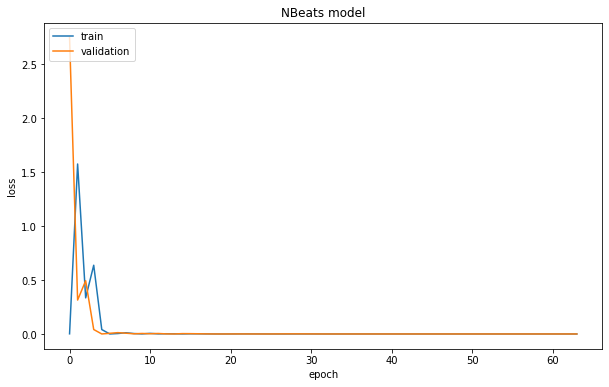

In [25]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('NBeats model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

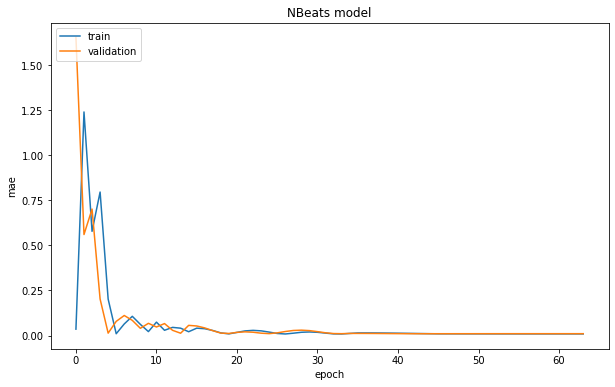

In [26]:
plt.figure(figsize=(10,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('NBeats model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

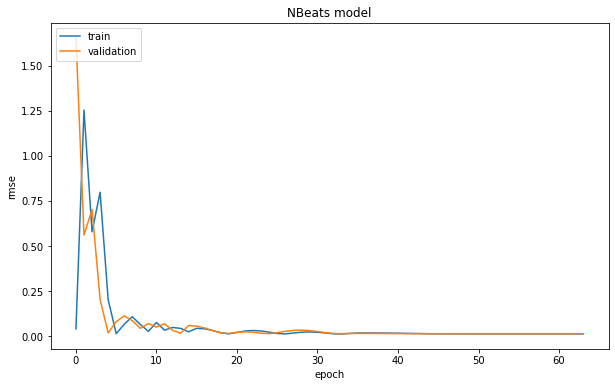

In [28]:
plt.figure(figsize=(10,6))
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('NBeats model')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

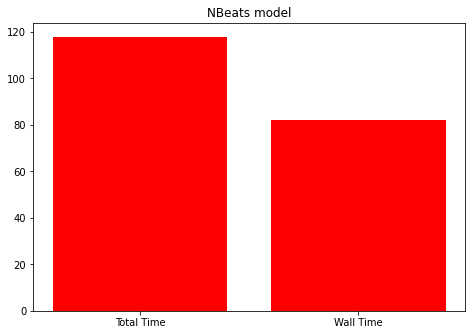

In [38]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Total Time', 'Wall Time']
time = [118,82]
ax.bar(x,time,color='r')
plt.title('NBeats model')
plt.show()

In [29]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 184ms/step - loss: 1.6424e-04 - root_mean_squared_error: 0.0128 - mae: 0.0101


[0.00016424196655862033, 0.012815692462027073, 0.010090596042573452]

In [30]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [31]:
# Make predictions with N-BEATS model
model_preds = make_preds(model, test_dataset)
model_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.04300126, 0.04705593, 0.05603839, 0.05242736, 0.05116784,
       0.05839145, 0.05767174, 0.06212549, 0.0695653 , 0.06402983],
      dtype=float32)>

In [32]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [33]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [34]:
# Evaluate N-BEATS model predictions
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 0.010090596,
 'mape': 17.084463,
 'mase': 1.1127156,
 'mse': 0.00016424197,
 'rmse': 0.012815692}

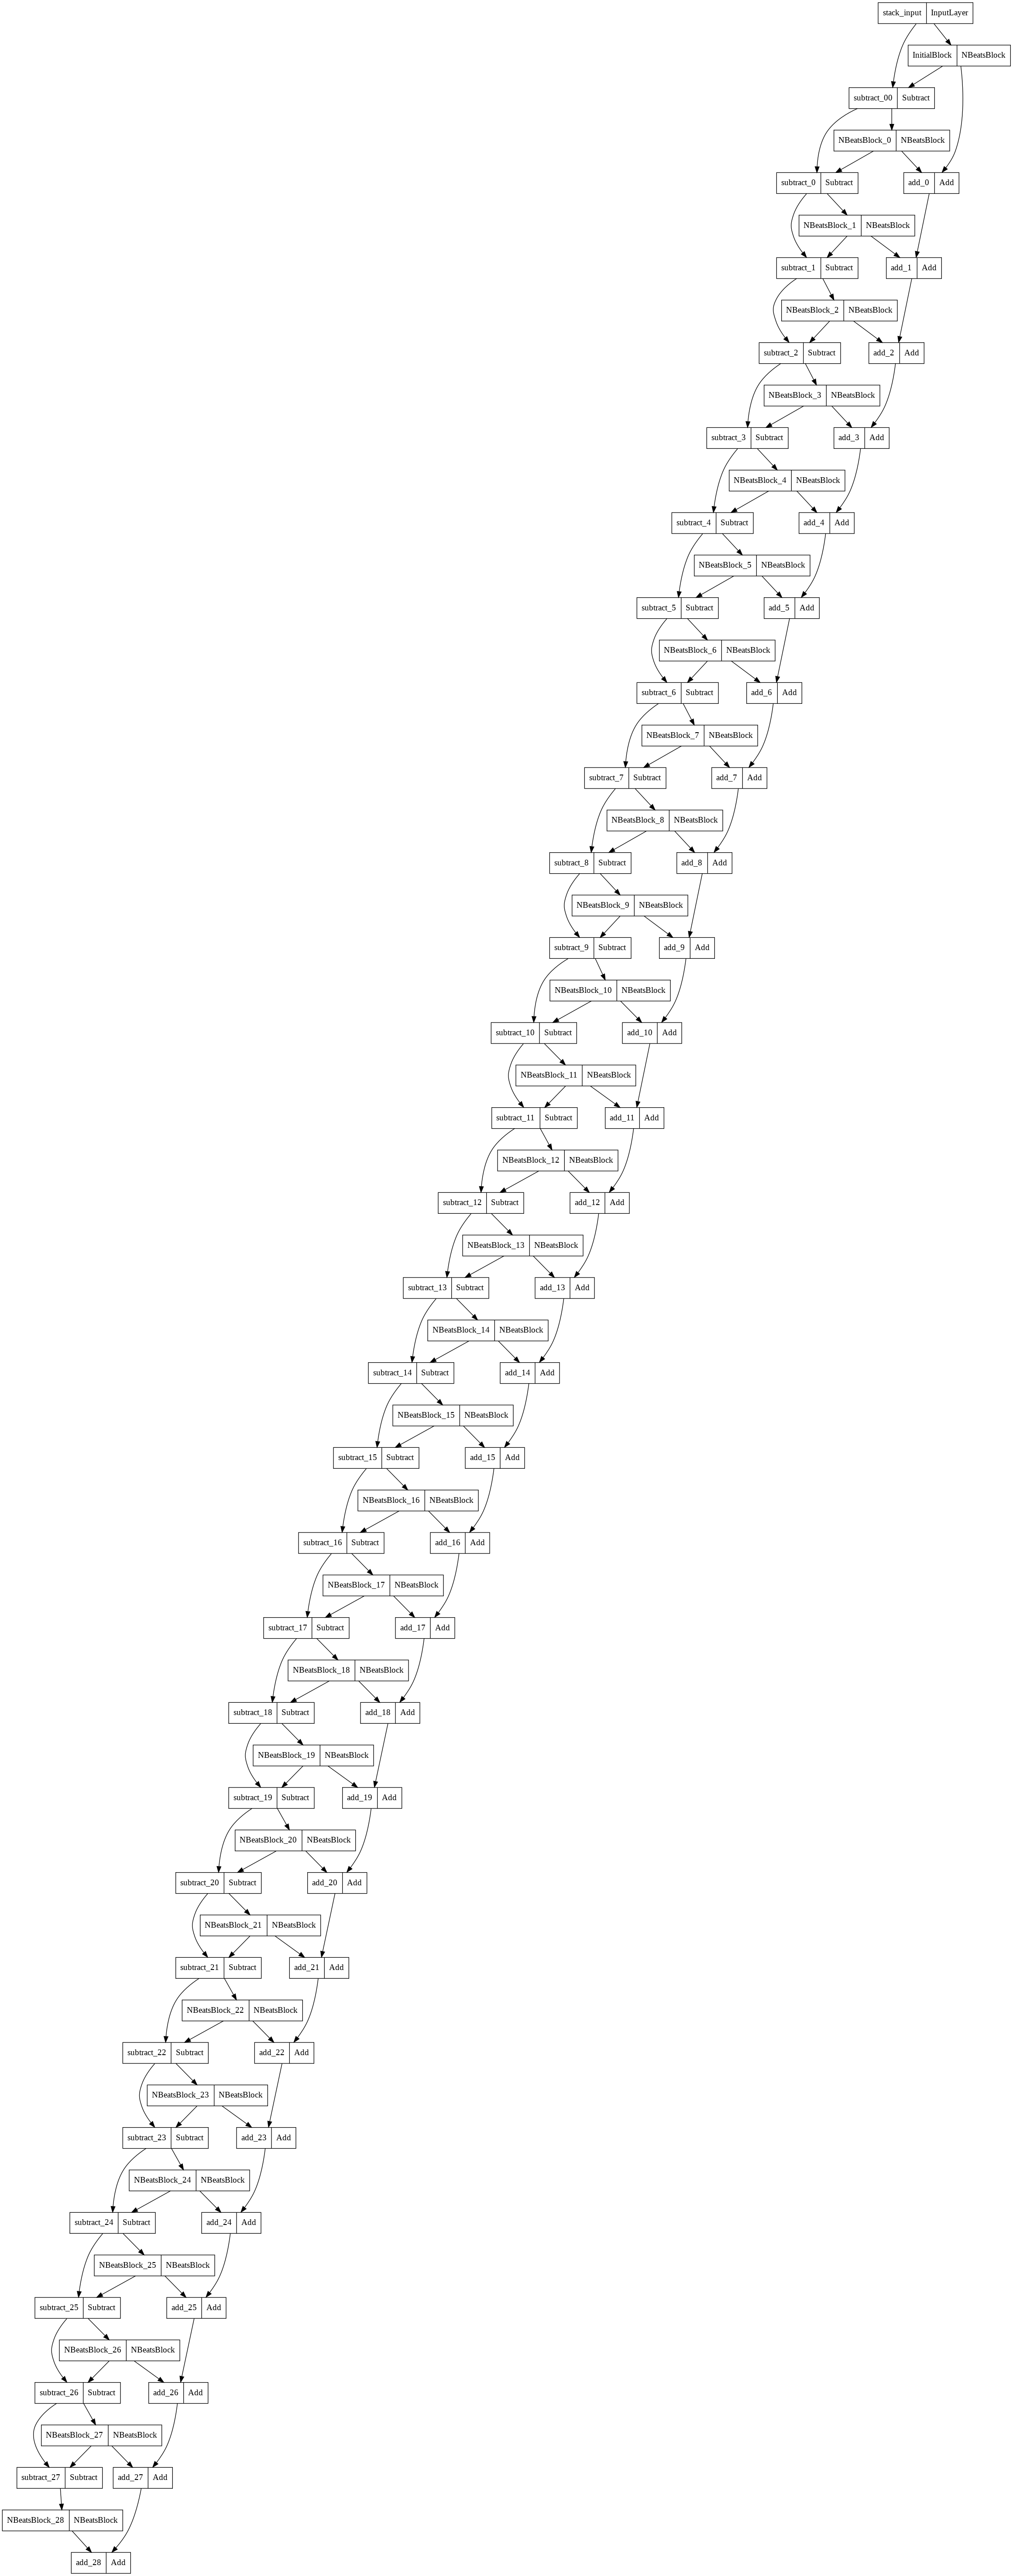

In [35]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model)

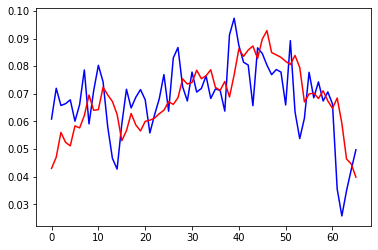

In [36]:
import matplotlib.pyplot as plt

x_axis = np.arange(len(model_preds))

plt.plot(x_axis, y_test, color='blue')
plt.plot(x_axis, model_preds, color='red')